# 8d. MEZXRF GeCMOS epithelial cell pellets with speed panel by IMC analysis
## 1. Summary
This notebook quantifies channel features and generates the figures associated with the IMC breast cancer microarray scans comprising Supplementary Figure 1 in the MEZ-XRF paper.

In [1]:
import sys
sys.path.insert(0, '..\\code\\')

import pathlib
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import hph_adata_analysis as hph_adata
import scanpy as sc
import anndata as ad

import seaborn as sns

from shutil import copyfile
from imctools.io.mcd.mcdparser import McdParser
from imctools.io.txt.txtparser import TxtParser

from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.pyplot import rc_context

from pymca_repack import unpack_pymca_h5, XrfImageMaskHDF

from skimage import filters
from skimage.transform import rescale, resize, downscale_local_mean

import high_plex_hdf as hph
import utilities

In [2]:
# Set data directory to work from 
base_dir = "C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF"
base_dir = pathlib.Path(base_dir)

# Specify the input directory where hdf files to process are located
input_dir = base_dir / 'data' / 'raw' / 'imc' / '20221215_TsH_ESRF2021Nov_cellpellet'

# Gather mcd ROIs for repackaging
imc_filepaths = list(input_dir.glob('*.txt'))
imc_filepaths = [imc_filepath for imc_filepath in imc_filepaths if 'st-' not in imc_filepath.stem]

# Make output directory for unpacked IMC files
out_dir = base_dir / 'data' / 'analysis' / 'imc' / '8d_imc_GeCMOS_speed_cell_pellet'
out_dir.mkdir(parents=True, exist_ok=True)
print('IMC epithelial cell pellet analysis will be output to: \n\t', out_dir) 

# Import csv of manually determined overlap coordinates between XRF and IMC
df_xrf_imc_overlap = pd.read_csv(base_dir / 'data' / 'raw' / 'imc_xrf_overlap_coords.csv')

# Import periodic table csv
df_periodic_table = pd.read_csv(base_dir / 'data' / 'raw' / 'xrf' / 'Periodic Table of Elements.csv')



IMC epithelial cell pellet analysis will be output to: 
	 C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\8d_imc_GeCMOS_speed_cell_pellet


In [3]:
 # Collect experiment antibody panel for additional channel information
panel_path = base_dir / 'data' / 'raw' / 'antibody_panels' / 'saber_cell_pellet_speed_panel.csv'

df_panel = pd.read_csv(panel_path)
df_panel

ab_tag  tag_isotope xrf_emission                 target  saber_rounds  \
0   Rh103          NaN        Rh_Ka                    DNA           NaN   
1    I127        127.0         I_Ka                    IdU           NaN   
2   La139        139.0        La_Ka  Progesterone Receptor           2.0   
3   Pr141        141.0        Pr_Ka                  Ki-67           2.0   
4   Sm152        152.0        Sm_Ka             Histone H3           2.0   
5   Gd158        158.0        Gd_Ka        c-erbB-2 - Her2           2.0   
6   Tb159        159.0        Tb_Ka     Keratin Epithelial           2.0   
7   Dy161        161.0        Dy_Ka          Cytokeratin 7           2.0   
8   Ho165        165.0        Ho_Ka          Cytokeratin 5           2.0   
9   Tm169        169.0        Tm_Ka     phospho histone h3           2.0   
10  Lu175        175.0        Lu_Ka               vimentin           2.0   
11  Ir191        191.0        Ir_L3                    DNA           NaN   
12  Ir193        193.0        Ir_L3                    DNA           NaN   

           shortname ab_clone  stock_conc_ug_per_ml  use_conc_ug_per_mL  \
0                DNA       Rh                   NaN                 NaN   
1                IdU      IdU                   NaN                 NaN   
2      PR (SABER x2)      NaN                   NaN                 NaN   
3   Ki-67 (SABER x2)      B56                   NaN                 NaN   
4     HH3 (SABER x2)     D1H2                   NaN                 NaN   
5    HER2 (SABER x2)    D8F12                   NaN                 NaN   
6   panCK (SABER x2)      AE3                   NaN                 NaN   
7     CK7 (SABER x2)   RCK105                   NaN                 NaN   
8     CK5 (SABER x2)  EP1601Y                   NaN                 NaN   
9    pHH3 (SABER x2)    HTA28                   NaN                 NaN   
10    Vim (SABER x2)  EPR3776                   NaN                 NaN   
11               DNA      NaN                   NaN                 NaN   
12               DNA      NaN                   NaN                 NaN   

    nuclear_segment  cell_segment  
0               1.0           NaN  
1               NaN           NaN  
2               NaN           NaN  
3               NaN           NaN  
4               1.0           NaN  
5               NaN           1.0  
6               NaN           1.0  
7               NaN           1.0  
8               NaN           1.0  
9               NaN           NaN  
10              NaN           1.0  
11              NaN           NaN  
12              NaN           NaN

In [4]:
hdf_substitute = {
    'mcf10a':'MCF10a',
    'a431':'A431',
    'zr751':'ZR-75-1',
    'skbr3':'SKBR3',
}

def imc_txt_to_hph(imc_filepath, df_panel, sample_name_ref, out_dir=None):
    acquisition_info = [
        'mcd_filepath',   
        'mcd_filename',   
        'acq_id',
        'acq_id_description',
        'step_um',
        'x_dim', 
        'y_dim',
    ]

    df_standard_measurements = pd.DataFrame(columns=acquisition_info)
    roi_dict = dict.fromkeys(acquisition_info)

    with TxtParser(imc_filepath) as parser:
        # Get acquisition
        acq_data = parser.get_acquisition_data()

        ## Collect key metadata for hdf packing
        roi_dict['mcd_filepath'] = str(imc_filepath)
        roi_dict['mcd_filename'] = str(imc_filepath.name)

        roi_dict['acq_id'] = acq_data.acquisition.id 
        roi_dict['acq_id_description'] = acq_data.acquisition.description

    #     assert(acq_data.acquisition.ablation_distance_between_shots_x == acq_data.acquisition.ablation_distance_between_shots_y)
        roi_dict['step_um'] = 0.5 # this may be accessible in mcd route, but not txt route, so defaults to 0.5
        roi_dict['x_dim'] = acq_data.acquisition.max_x
        roi_dict['y_dim'] = acq_data.acquisition.max_y

        ## Collect key channel information
        df_channels = pd.DataFrame(
            {
                'channel_labels':acq_data.channel_labels,
                'channel_masses':acq_data.channel_masses,
                'channel_names':acq_data.channel_names,
            }
        )

        ## Add panel information to channel information
        # Convert for panel merge
        df_channels['channel_masses'] = (pd.to_numeric(df_channels['channel_masses']))  

        # Panel merge
        df_channel_metadata = pd.merge(
            df_channels, 
            df_panel, 
            left_on='channel_masses', 
            right_on='tag_isotope', 
            how='left'
        ) 

        # Log channels loaded with a marker
        df_channel_metadata['loaded_channel'] = df_channel_metadata['channel_masses'].isin(df_panel['tag_isotope'])

        # Make longname for IMC samples
        df_channel_metadata['shortname'] = df_channel_metadata['shortname'].astype(str)
        df_channel_metadata['longname_imc'] = (
            df_channel_metadata[['channel_names', 'shortname']].agg(' | '.join, axis=1)
            )  
        
        # Add plot channel name
        df_channel_metadata['plot_channel'] = df_channel_metadata['longname_imc']

        ## Get image stack    
        img_stack = np.moveaxis(
            acq_data.image_data, 
            source=[0, 1, 2], 
            destination=[2, 1, 0],
        )
        img_stack = np.flip(img_stack, axis=1)[:250,:250,:]
        
        print(img_stack.shape)

        # Package to hph object
        roi_hph = hph.HighPlexHdf(
            images = {'raw':img_stack},
            channel_metadata = df_channel_metadata,
            masks = {},
            sample_metadata=roi_dict
        )
        
        roi_hph.sample_metadata['sample_name_ref'] = sample_name_ref
        roi_hph.sample_metadata['AB_panel'] = panel_path.stem
        
        if isinstance(out_dir, pathlib.Path):
            if out_dir.is_dir():
                output_fpath = out_dir / f"{sample_name_ref}.h5"            
                roi_hph.export_hdf(
                    output_fpath = output_fpath
                )
  
    return roi_hph, df_channel_metadata

for imc_filepath in imc_filepaths[:]:
    sample_name = hdf_substitute[imc_filepath.stem.split('_')[-2]]
    roi_hph, df_channel_metadata = imc_txt_to_hph(imc_filepath, df_panel=df_panel, sample_name_ref=sample_name, out_dir=out_dir)

df_channel_metadata


(250, 250, 27)
(250, 250, 27)
(250, 250, 27)
(250, 250, 27)


channel_labels  channel_masses channel_names ab_tag  tag_isotope  \
0       89Y(Y89Di)              89           Y89    NaN          NaN   
1   103Rh(Rh103Di)             103         Rh103    NaN          NaN   
2   115In(In115Di)             115         In115    NaN          NaN   
3     127I(I127Di)             127          I127   I127        127.0   
4   139La(La139Di)             139         La139  La139        139.0   
5   140Ce(Ce140Di)             140         Ce140    NaN          NaN   
6   141Pr(Pr141Di)             141         Pr141  Pr141        141.0   
7   144Nd(Nd144Di)             144         Nd144    NaN          NaN   
8   145Nd(Nd145Di)             145         Nd145    NaN          NaN   
9   148Nd(Nd148Di)             148         Nd148    NaN          NaN   
10  151Eu(Eu151Di)             151         Eu151    NaN          NaN   
11  152Sm(Sm152Di)             152         Sm152  Sm152        152.0   
12  153Eu(Eu153Di)             153         Eu153    NaN          NaN   
13  154Sm(Sm154Di)             154         Sm154    NaN          NaN   
14  155Gd(Gd155Di)             155         Gd155    NaN          NaN   
15  156Gd(Gd156Di)             156         Gd156    NaN          NaN   
16  158Gd(Gd158Di)             158         Gd158  Gd158        158.0   
17  159Tb(Tb159Di)             159         Tb159  Tb159        159.0   
18  161Dy(Dy161Di)             161         Dy161  Dy161        161.0   
19  165Ho(Ho165Di)             165         Ho165  Ho165        165.0   
20  166Er(Er166Di)             166         Er166    NaN          NaN   
21  169Tm(Tm169Di)             169         Tm169  Tm169        169.0   
22  171Yb(Yb171Di)             171         Yb171    NaN          NaN   
23  172Yb(Yb172Di)             172         Yb172    NaN          NaN   
24  175Lu(Lu175Di)             175         Lu175  Lu175        175.0   
25  191Ir(Ir191Di)             191         Ir191  Ir191        191.0   
26  193Ir(Ir193Di)             193         Ir193  Ir193        193.0   

   xrf_emission                 target  saber_rounds         shortname  \
0           NaN                    NaN           NaN               nan   
1           NaN                    NaN           NaN               nan   
2           NaN                    NaN           NaN               nan   
3          I_Ka                    IdU           NaN               IdU   
4         La_Ka  Progesterone Receptor           2.0     PR (SABER x2)   
5           NaN                    NaN           NaN               nan   
6         Pr_Ka                  Ki-67           2.0  Ki-67 (SABER x2)   
7           NaN                    NaN           NaN               nan   
8           NaN                    NaN           NaN               nan   
9           NaN                    NaN           NaN               nan   
10          NaN                    NaN           NaN               nan   
11        Sm_Ka             Histone H3           2.0    HH3 (SABER x2)   
12          NaN                    NaN           NaN               nan   
13          NaN                    NaN           NaN               nan   
14          NaN                    NaN           NaN               nan   
15          NaN                    NaN           NaN               nan   
16        Gd_Ka        c-erbB-2 - Her2           2.0   HER2 (SABER x2)   
17        Tb_Ka     Keratin Epithelial           2.0  panCK (SABER x2)   
18        Dy_Ka          Cytokeratin 7           2.0    CK7 (SABER x2)   
19        Ho_Ka          Cytokeratin 5           2.0    CK5 (SABER x2)   
20          NaN                    NaN           NaN               nan   
21        Tm_Ka     phospho histone h3           2.0   pHH3 (SABER x2)   
22          NaN                    NaN           NaN               nan   
23          NaN                    NaN           NaN               nan   
24        Lu_Ka               vimentin           2.0    Vim (SABER x2)   
25        Ir_L3                    DNA           NaN           

## Segment IMC data


 Segmented hdf files will be output to: 
	 C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\8d_imc_GeCMOS_speed_cell_pellet\segmented
pixel size:  0.5


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


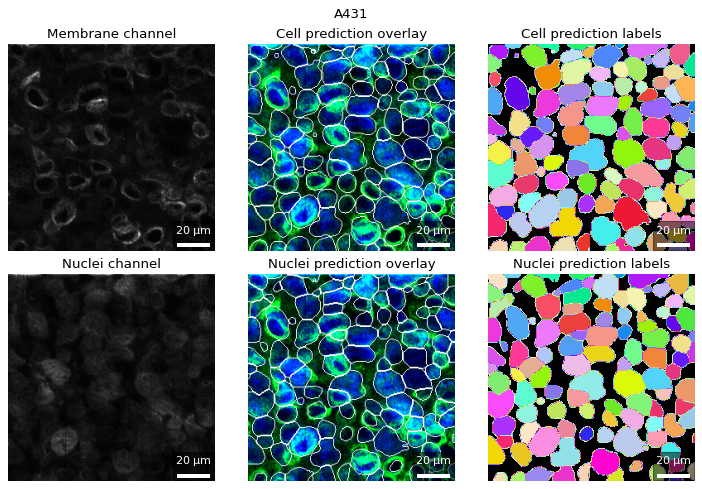

matched_cell_mask 101
matched_nuclei_mask 101
matched_non_nuclei_mask 101


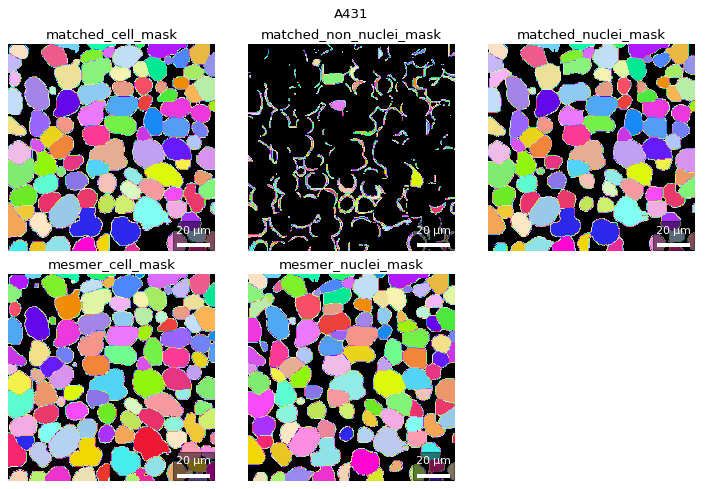

pixel size:  0.5


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


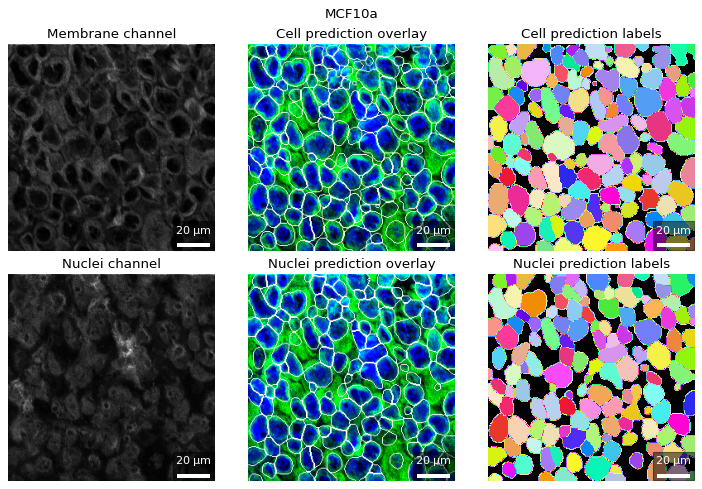

matched_cell_mask 127
matched_nuclei_mask 127
matched_non_nuclei_mask 127


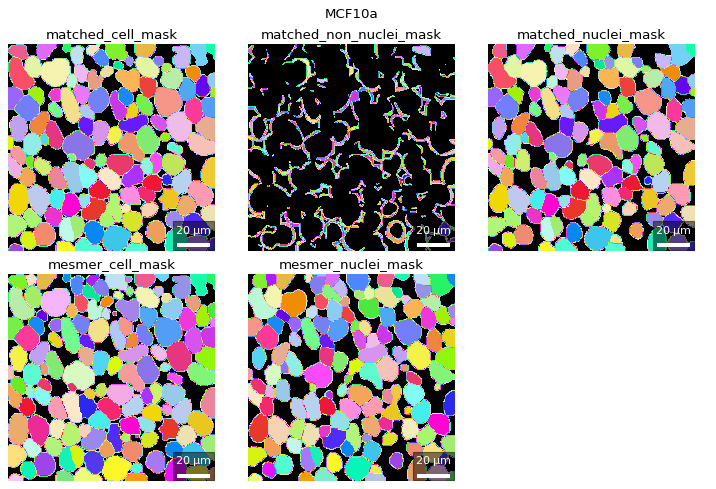

pixel size:  0.5


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


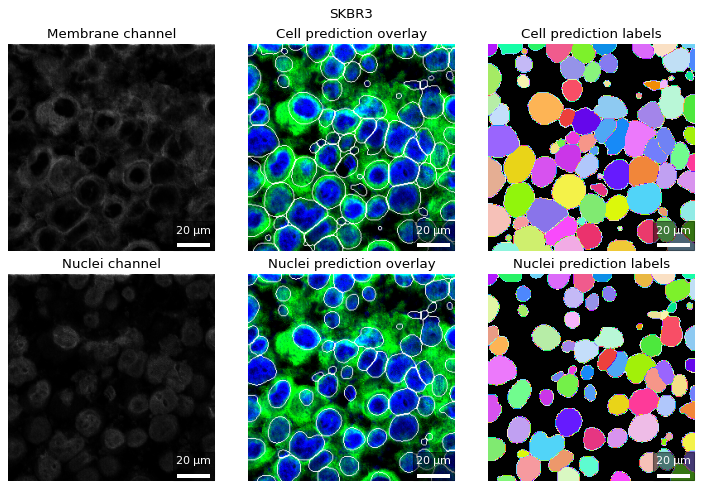

matched_cell_mask 70
matched_nuclei_mask 70
matched_non_nuclei_mask 70


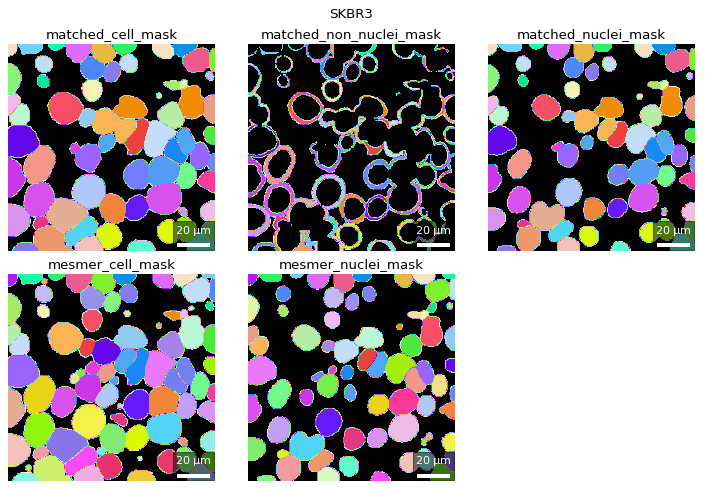

pixel size:  0.5


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


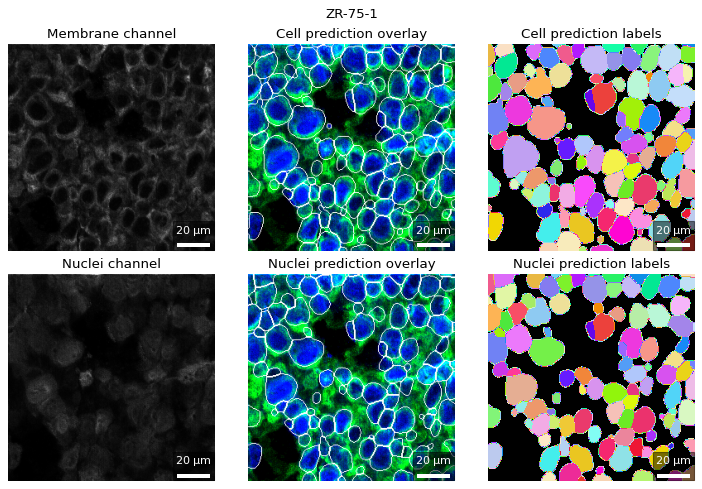

matched_cell_mask 91
matched_nuclei_mask 91
matched_non_nuclei_mask 91


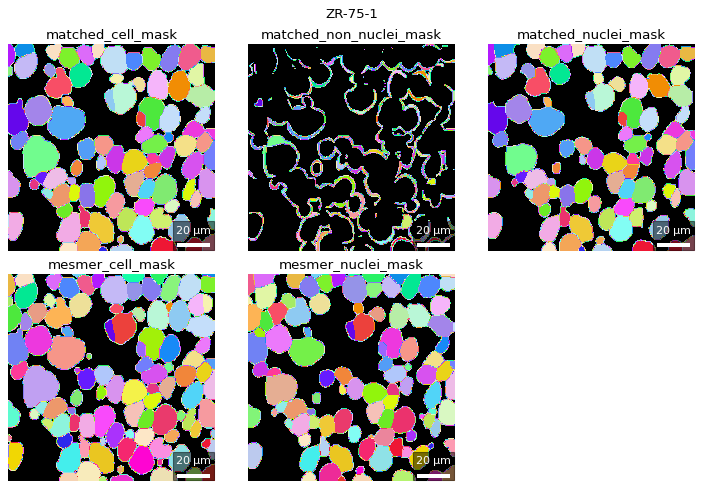

In [5]:
# Make output directory segmented images
out_sub_dir = out_dir / 'segmented'
out_sub_dir.mkdir(parents=True, exist_ok=True)
print('\n Segmented hdf files will be output to: \n\t',out_sub_dir) 

hdfs_to_segment = list(out_dir.glob('*.h5'))
hdfs_to_segment = [hdf_to_segment for hdf_to_segment in hdfs_to_segment if 'MCF7' not in hdf_to_segment.stem]

for hdf_fpath in hdfs_to_segment[:]:    
    hdf_segment = hph.hdf_to_HighPlex_Hdf(hdf_fpath=hdf_fpath)
    
    # Run segmentation
    # Parameters explained here https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Mesmer-Application.ipynb
    hdf_segment.mesmer_segment()
    hdf_segment.mesmer_output_plot(out_dir = out_sub_dir)
    hdf_segment.cell_nuclei_match()
    hdf_segment.segmented_masks_plot(out_dir = out_sub_dir)
    hdf_segment.export_masks_to_source_hdf()
    
for source_fpath in hdfs_to_segment:
    output_fpath = out_sub_dir / f'{source_fpath.stem}_segmented.h5'
    source = copyfile(source_fpath, output_fpath)         

## Single cell analysis measurements of IMC data
Measure intensities for all cell masks

In [4]:
# hdf_analysis_filepaths = [hdf_analysis_path for hdf_analysis_path in hdfs_to_segment if 'MCF7' not in hdf_analysis_path.stem]
# The order determines how loaded into hdf, and order of later output images
hdf_analysis_filepaths = [
    pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8d_imc_GeCMOS_speed_cell_pellet/MCF10a.h5'),
    pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8d_imc_GeCMOS_speed_cell_pellet/A431.h5'),
    pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8d_imc_GeCMOS_speed_cell_pellet/ZR-75-1.h5'),
    pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8d_imc_GeCMOS_speed_cell_pellet/SKBR3.h5'),]


hdf_analysis_filepaths

[WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8d_imc_GeCMOS_speed_cell_pellet/MCF10a.h5'),
 WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8d_imc_GeCMOS_speed_cell_pellet/A431.h5'),
 WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8d_imc_GeCMOS_speed_cell_pellet/ZR-75-1.h5'),
 WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8d_imc_GeCMOS_speed_cell_pellet/SKBR3.h5')]

In [7]:
# All cell mask
image_n = 'raw'
mask_n = 'mesmer_cell_mask'
adata = hph.multiple_hph_to_adata(
    hdf_filepaths = hdf_analysis_filepaths, 
    image_n = image_n,
    mask_n = mask_n
)
# Correct variable names
isotopes = [i[0] for i in adata.var.index.str.split(' ', expand=True)]
adata.var['ab_tag'] = isotopes
adata.var['ab_tag'] = adata.var['ab_tag'].astype(str)
adata.var['longname'] = adata.var.index
adata.var = adata.var.merge(df_panel, on='ab_tag', how='left', suffixes=('', '_y'))
adata.var.drop(adata.var.filter(regex='_y$').columns, axis=1, inplace=True)
adata.write(out_dir.joinpath(f'IMCofGeCMOS_cell_pellets_adata_{mask_n}.h5ad'))

# Matched cell mask
image_n = 'raw'
mask_n = 'matched_cell_mask'
adata = hph.multiple_hph_to_adata(
    hdf_filepaths = hdf_analysis_filepaths, 
    image_n = image_n,
    mask_n = mask_n
)
# Correct variable names
isotopes = [i[0] for i in adata.var.index.str.split(' ', expand=True)]
adata.var['ab_tag'] = isotopes
adata.var['ab_tag'] = adata.var['ab_tag'].astype(str)
adata.var['longname'] = adata.var.index
adata.var = adata.var.merge(df_panel, on='ab_tag', how='left', suffixes=('', '_y'))
adata.var.drop(adata.var.filter(regex='_y$').columns, axis=1, inplace=True)
adata.write(out_dir.joinpath(f'IMCofGeCMOS_cell_pellets_adata_{mask_n}.h5ad'))


# Matched nuclear mask
mask_n = 'matched_nuclei_mask'
adata = hph.multiple_hph_to_adata(
    hdf_filepaths = hdf_analysis_filepaths, 
    image_n = image_n,
    mask_n = mask_n
)
# Correct variable names
isotopes = [i[0] for i in adata.var.index.str.split(' ', expand=True)]
adata.var['ab_tag'] = isotopes
adata.var['ab_tag'] = adata.var['ab_tag'].astype(str)
adata.var['longname'] = adata.var.index
adata.var = adata.var.merge(df_panel, on='ab_tag', how='left', suffixes=('', '_y'))
adata.var.drop(adata.var.filter(regex='_y$').columns, axis=1, inplace=True)
adata.write(out_dir.joinpath(f'IMCofGeCMOS_cell_pellets_adata_{mask_n}.h5ad'))


# Non-nuclear mask
mask_n = 'matched_non_nuclei_mask'
adata = hph.multiple_hph_to_adata(
    hdf_filepaths = hdf_analysis_filepaths, 
    image_n = image_n,
    mask_n = mask_n
)
# Correct variable names
isotopes = [i[0] for i in adata.var.index.str.split(' ', expand=True)]
adata.var['ab_tag'] = isotopes
adata.var['ab_tag'] = adata.var['ab_tag'].astype(str)
adata.var['longname'] = adata.var.index
adata.var = adata.var.merge(df_panel, on='ab_tag', how='left', suffixes=('', '_y'))
adata.var.drop(adata.var.filter(regex='_y$').columns, axis=1, inplace=True)
adata.write(out_dir.joinpath(f'IMCofGeCMOS_cell_pellets_adata_{mask_n}.h5ad'))


AnnData expects .var.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
... storing 'label_id' as categorical
... storing 'sample_name_ref' as categorical
... storing 'AB_panel' as categorical
... storing 'hph_mask_key' as categorical
... storing 'hph_image_key' as categorical
... storing 'hph_id' as categorical
... storing 'shortname' as categorical
... storing 'xrf_emission' as categorical
... storing 'target' as categorical
... storing 'ab_clone' as categorical
AnnData expects .var.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
... storing 'label_id' as categorical
... storing 'sample_name_ref' as categorical
... storing 'AB_panel' as categorical
... storing 'hph_mask_key' as categorical
... storing 'hph_image_key' as categorical
... storing 'hph_id' as categorical
... storing 'shortname' as categorical
... storing 'xrf_emission' as categorical
... storing 'target' as categorical
... storing 'ab_clon

## Single cell analysis

In [5]:
adata = ad.read_h5ad(out_dir.joinpath('IMCofGeCMOS_cell_pellets_adata_matched_cell_mask.h5ad'))
adata.var.index = adata.var['xrf_emission']
adata.var

C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


shortname                  longname ab_tag  tag_isotope  \
xrf_emission                                                                   
I_Ka                       IdU                I127 | IdU   I127        127.0   
La_Ka            PR (SABER x2)     La139 | PR (SABER x2)  La139        139.0   
Pr_Ka         Ki-67 (SABER x2)  Pr141 | Ki-67 (SABER x2)  Pr141        141.0   
Sm_Ka           HH3 (SABER x2)    Sm152 | HH3 (SABER x2)  Sm152        152.0   
Gd_Ka          HER2 (SABER x2)   Gd158 | HER2 (SABER x2)  Gd158        158.0   
Tb_Ka         panCK (SABER x2)  Tb159 | panCK (SABER x2)  Tb159        159.0   
Dy_Ka           CK7 (SABER x2)    Dy161 | CK7 (SABER x2)  Dy161        161.0   
Ho_Ka           CK5 (SABER x2)    Ho165 | CK5 (SABER x2)  Ho165        165.0   
Tm_Ka          pHH3 (SABER x2)   Tm169 | pHH3 (SABER x2)  Tm169        169.0   
Lu_Ka           Vim (SABER x2)    Lu175 | Vim (SABER x2)  Lu175        175.0   
Ir_L3                      DNA               Ir191 | DNA  Ir191        191.0   
Ir_L3                      DNA               Ir193 | DNA  Ir193        193.0   

             xrf_emission                 target  saber_rounds ab_clone  \
xrf_emission                                                              
I_Ka                 I_Ka                    IdU           NaN      IdU   
La_Ka               La_Ka  Progesterone Receptor           2.0      nan   
Pr_Ka               Pr_Ka                  Ki-67           2.0      B56   
Sm_Ka               Sm_Ka             Histone H3           2.0     D1H2   
Gd_Ka               Gd_Ka        c-erbB-2 - Her2           2.0    D8F12   
Tb_Ka               Tb_Ka     Keratin Epithelial           2.0      AE3   
Dy_Ka               Dy_Ka          Cytokeratin 7           2.0   RCK105   
Ho_Ka               Ho_Ka          Cytokeratin 5           2.0  EP1601Y   
Tm_Ka               Tm_Ka     phospho histone h3           2.0    HTA28   
Lu_Ka               Lu_Ka               vimentin           2.0  EPR3776   
Ir_L3               Ir_L3                    DNA           NaN      nan   
Ir_L3               Ir_L3                    DNA           NaN      nan   

              stock_conc_ug_per_ml  use_conc_ug_per_mL  nuclear_segment  \
xrf_emission                                                              
I_Ka                           NaN                 NaN              NaN   
La_Ka                          NaN                 NaN              NaN   
Pr_Ka                          NaN                 NaN              NaN   
Sm_Ka                          NaN                 NaN              1.0   
Gd_Ka                          NaN                 NaN              NaN   
Tb_Ka                          NaN                 NaN              NaN   
Dy_Ka                          NaN                 NaN              NaN   
Ho_Ka                          NaN                 NaN              NaN   
Tm_Ka                          NaN                 NaN              NaN   
Lu_Ka                          NaN                 NaN              NaN   
Ir_L3                          NaN                 NaN              NaN   
Ir_L3                          NaN                 NaN              NaN   

              cell_segment  
xrf_emission                
I_Ka                   NaN  
La_Ka                  NaN  
Pr_Ka                  NaN  
Sm_Ka                  NaN  
Gd_Ka                  1.0  
Tb_Ka                  1.0  
Dy_Ka                  1.0  
Ho_Ka                  1.0  
Tm_Ka                  NaN  
Lu_Ka                  1.0  
Ir_L3                  NaN  
Ir_L3                  NaN

In [6]:
adata.var['SABER'] = adata.var['longname'].str.split(' ', expand=True).iloc[:,-2] + ' ' + adata.var['longname'].str.split(' ', expand=True).iloc[:,-1]
adata.var['SABER'] = adata.var['SABER'].fillna('')
adata.var['longname_mod'] = adata.var['ab_tag'] + ' | ' + adata.var['ab_tag'] + '#' + adata.var['SABER']

adata.var

shortname                  longname ab_tag  tag_isotope  \
xrf_emission                                                                   
I_Ka                       IdU                I127 | IdU   I127        127.0   
La_Ka            PR (SABER x2)     La139 | PR (SABER x2)  La139        139.0   
Pr_Ka         Ki-67 (SABER x2)  Pr141 | Ki-67 (SABER x2)  Pr141        141.0   
Sm_Ka           HH3 (SABER x2)    Sm152 | HH3 (SABER x2)  Sm152        152.0   
Gd_Ka          HER2 (SABER x2)   Gd158 | HER2 (SABER x2)  Gd158        158.0   
Tb_Ka         panCK (SABER x2)  Tb159 | panCK (SABER x2)  Tb159        159.0   
Dy_Ka           CK7 (SABER x2)    Dy161 | CK7 (SABER x2)  Dy161        161.0   
Ho_Ka           CK5 (SABER x2)    Ho165 | CK5 (SABER x2)  Ho165        165.0   
Tm_Ka          pHH3 (SABER x2)   Tm169 | pHH3 (SABER x2)  Tm169        169.0   
Lu_Ka           Vim (SABER x2)    Lu175 | Vim (SABER x2)  Lu175        175.0   
Ir_L3                      DNA               Ir191 | DNA  Ir191        191.0   
Ir_L3                      DNA               Ir193 | DNA  Ir193        193.0   

             xrf_emission                 target  saber_rounds ab_clone  \
xrf_emission                                                              
I_Ka                 I_Ka                    IdU           NaN      IdU   
La_Ka               La_Ka  Progesterone Receptor           2.0      nan   
Pr_Ka               Pr_Ka                  Ki-67           2.0      B56   
Sm_Ka               Sm_Ka             Histone H3           2.0     D1H2   
Gd_Ka               Gd_Ka        c-erbB-2 - Her2           2.0    D8F12   
Tb_Ka               Tb_Ka     Keratin Epithelial           2.0      AE3   
Dy_Ka               Dy_Ka          Cytokeratin 7           2.0   RCK105   
Ho_Ka               Ho_Ka          Cytokeratin 5           2.0  EP1601Y   
Tm_Ka               Tm_Ka     phospho histone h3           2.0    HTA28   
Lu_Ka               Lu_Ka               vimentin           2.0  EPR3776   
Ir_L3               Ir_L3                    DNA           NaN      nan   
Ir_L3               Ir_L3                    DNA           NaN      nan   

              stock_conc_ug_per_ml  use_conc_ug_per_mL  nuclear_segment  \
xrf_emission                                                              
I_Ka                           NaN                 NaN              NaN   
La_Ka                          NaN                 NaN              NaN   
Pr_Ka                          NaN                 NaN              NaN   
Sm_Ka                          NaN                 NaN              1.0   
Gd_Ka                          NaN                 NaN              NaN   
Tb_Ka                          NaN                 NaN              NaN   
Dy_Ka                          NaN                 NaN              NaN   
Ho_Ka                          NaN                 NaN              NaN   
Tm_Ka                          NaN                 NaN              NaN   
Lu_Ka                          NaN                 NaN              NaN   
Ir_L3                          NaN                 NaN              NaN   
Ir_L3                          NaN                 NaN              NaN   

              cell_segment       SABER              longname_mod  
xrf_emission                                                      
I_Ka                   NaN                          I127 | I127#  
La_Ka                  NaN  (SABER x2)  La139 | La139#(SABER x2)  
Pr_Ka                  NaN  (SABER x2)  Pr141 | Pr141#(SABER x2)  
Sm_Ka                  NaN  (SABER x2)  Sm152 | Sm152#(SABER x2)  
Gd_Ka                  1.0  (SABER x2)  Gd158 | Gd158#(SABER x2)  
Tb_Ka                  1.0  (SABER x2)  Tb159 | Tb159#(SABER x2)  
Dy_Ka                  1.0  (SABER x2)  Dy161 | Dy161#(SABER x2)  
Ho_Ka                  1.0  (SABER x2)  Ho165 | Ho165#(SABER x2)  
Tm_Ka                  NaN  (SABER x2)  Tm169 | Tm169#(SABER x2)  
Lu_Ka                  1.0  (SABER x2)  Lu175 | Lu175#(SABER 

In [7]:
adata.var['longname_mod'].str.split('#', expand=True)

0           1
xrf_emission                           
I_Ka            I127 | I127            
La_Ka         La139 | La139  (SABER x2)
Pr_Ka         Pr141 | Pr141  (SABER x2)
Sm_Ka         Sm152 | Sm152  (SABER x2)
Gd_Ka         Gd158 | Gd158  (SABER x2)
Tb_Ka         Tb159 | Tb159  (SABER x2)
Dy_Ka         Dy161 | Dy161  (SABER x2)
Ho_Ka         Ho165 | Ho165  (SABER x2)
Tm_Ka         Tm169 | Tm169  (SABER x2)
Lu_Ka         Lu175 | Lu175  (SABER x2)
Ir_L3         Ir191 | Ir191            
Ir_L3         Ir193 | Ir193

C:\Users\MerrickS\OneDrive\OneNote Notebook\Git\mez_xrf_paper\scripts\hph_adata_analysis.py:392: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels_padded)  # vertically oriented colorbar


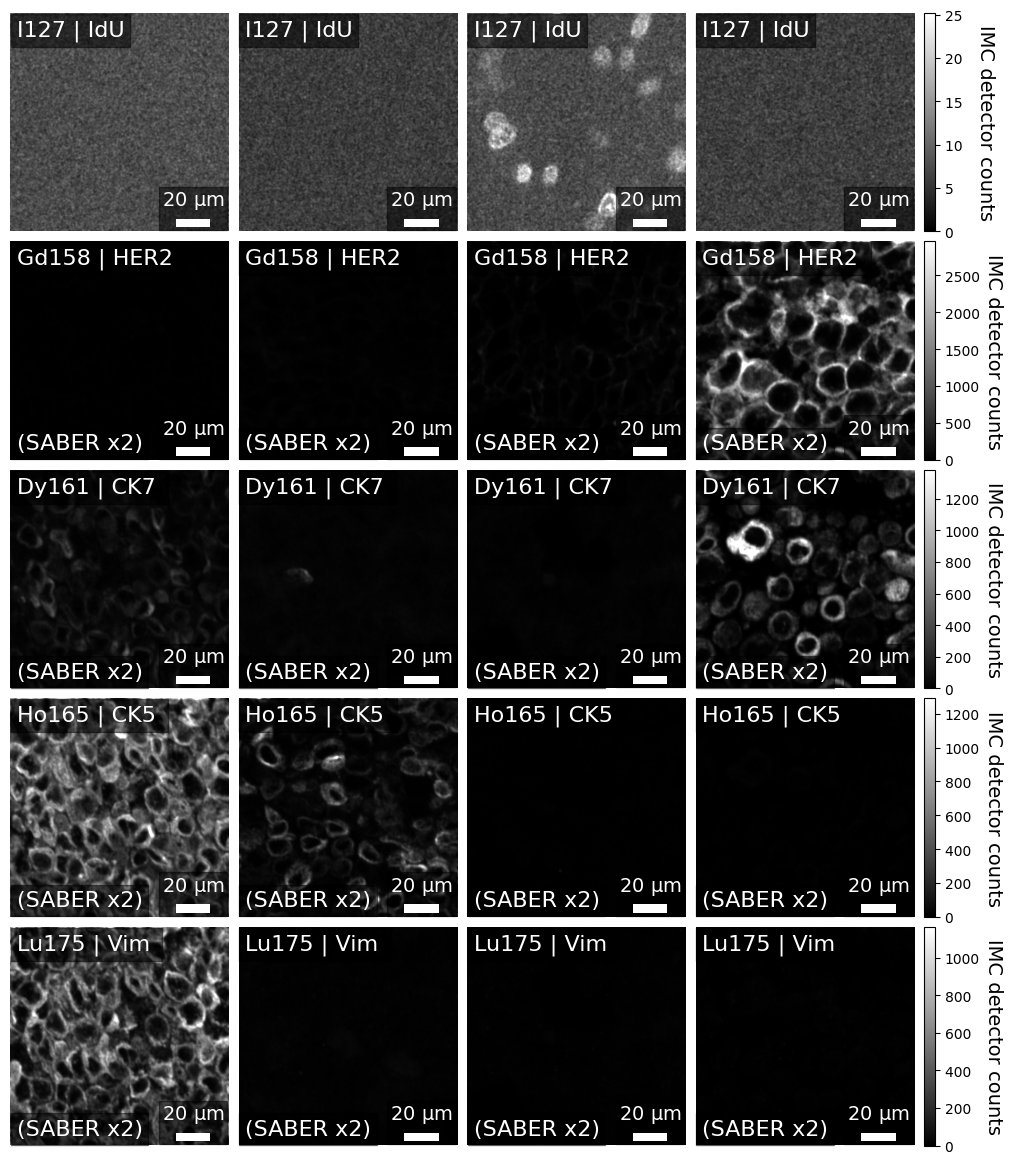

In [8]:
from importlib import reload  # Python 3.4+
reload(hph_adata)

all_channels = [
    'I_Ka',
    'La_Ka',
    'Pr_Ka',
    'Sm_Ka',
    'Gd_Ka',
    'Tb_Ka',
    'Dy_Ka',
    'Ho_Ka',
    'Tm_Ka',
    'Lu_Ka',
    'Ir_L3',
    ]

fig5_imc_channels = [
    'I_Ka',
    'Gd_Ka',
    'Dy_Ka',
    'Ho_Ka',
    'Lu_Ka',
]


hph_adata.adata_hph_channels_plot(
    adata,
    plot_channels = fig5_imc_channels,
    hdf_ids = ['MCF10a', 'A431', 'ZR-75-1', 'SKBR3'],
    plot_name= 'longname',
    plot_name_split = '(',
    legend_fontsize = 16,
    color_bar_label = 'IMC detector counts'
)

## Speed cell pellet signal to noise comparison

In [12]:
adata.obs['Hz'] = 200
df_to_map = adata.var
df_to_map['Symbol'] = df_to_map['xrf_emission'].str.split('_', expand=True).iloc[:,0]
df_to_map = pd.merge(df_to_map, df_periodic_table[['AtomicNumber', 'Element', 'Symbol']], on='Symbol')
df_to_map = df_to_map.iloc[:-1,:]
df_to_map

shortname                  longname ab_tag  tag_isotope  \
0                IdU                I127 | IdU   I127        127.0   
1      PR (SABER x2)     La139 | PR (SABER x2)  La139        139.0   
2   Ki-67 (SABER x2)  Pr141 | Ki-67 (SABER x2)  Pr141        141.0   
3     HH3 (SABER x2)    Sm152 | HH3 (SABER x2)  Sm152        152.0   
4    HER2 (SABER x2)   Gd158 | HER2 (SABER x2)  Gd158        158.0   
5   panCK (SABER x2)  Tb159 | panCK (SABER x2)  Tb159        159.0   
6     CK7 (SABER x2)    Dy161 | CK7 (SABER x2)  Dy161        161.0   
7     CK5 (SABER x2)    Ho165 | CK5 (SABER x2)  Ho165        165.0   
8    pHH3 (SABER x2)   Tm169 | pHH3 (SABER x2)  Tm169        169.0   
9     Vim (SABER x2)    Lu175 | Vim (SABER x2)  Lu175        175.0   
10               DNA               Ir191 | DNA  Ir191        191.0   

   xrf_emission                 target  saber_rounds ab_clone  \
0          I_Ka                    IdU           NaN      IdU   
1         La_Ka  Progesterone Receptor           2.0      nan   
2         Pr_Ka                  Ki-67           2.0      B56   
3         Sm_Ka             Histone H3           2.0     D1H2   
4         Gd_Ka        c-erbB-2 - Her2           2.0    D8F12   
5         Tb_Ka     Keratin Epithelial           2.0      AE3   
6         Dy_Ka          Cytokeratin 7           2.0   RCK105   
7         Ho_Ka          Cytokeratin 5           2.0  EP1601Y   
8         Tm_Ka     phospho histone h3           2.0    HTA28   
9         Lu_Ka               vimentin           2.0  EPR3776   
10        Ir_L3                    DNA           NaN      nan   

    stock_conc_ug_per_ml  use_conc_ug_per_mL  nuclear_segment  cell_segment  \
0                    NaN                 NaN              NaN           NaN   
1                    NaN                 NaN              NaN           NaN   
2                    NaN                 NaN              NaN           NaN   
3                    NaN                 NaN              1.0           NaN   
4                    NaN                 NaN              NaN           1.0   
5                    NaN                 NaN              NaN           1.0   
6                    NaN                 NaN              NaN           1.0   
7                    NaN                 NaN              NaN           1.0   
8                    NaN                 NaN              NaN           NaN   
9                    NaN                 NaN              NaN           1.0   
10                   NaN                 NaN              NaN           NaN   

         SABER              longname_mod Symbol  AtomicNumber       Element  
0                           I127 | I127#      I            53        Iodine  
1   (SABER x2)  La139 | La139#(SABER x2)     La            57     Lanthanum  
2   (SABER x2)  Pr141 | Pr141#(SABER x2)     Pr            59  Praseodymium  
3   (SABER x2)  Sm152 | Sm152#(SABER x2)     Sm            62      Samarium  
4   (SABER x2)  Gd158 | Gd158#(SABER x2)     Gd            64    Gadolinium  
5   (SABER x2)  Tb159 | Tb159#(SABER x2)     Tb            65       Terbium  
6   (SABER x2)  Dy161 | Dy161#(SABER x2)     Dy            66    Dysprosium  
7   (SABER x2)  Ho165 | Ho165#(SABER x2)     Ho            67       Holmium  
8   (SABER x2)  Tm169 | Tm169#(SABER x2)     Tm            69       Thulium  
9   (SABER x2)  Lu175 | Lu175#(SABER x2)     Lu            71      Lutetium  
10                        Ir191 | Ir191#     Ir            77       Iridium

In [13]:
df_signal_to_noise = pd.DataFrame()
for hz in adata.obs['Hz'].unique():
    row = {}
    row['Hz'] = hz
    adata_Hz = adata[adata.obs['Hz'] == hz]
    for var_name in adata_Hz.var_names:
        row['var_name'] = var_name

        var_values = adata_Hz[:,var_name].X

        # Sample the max and mean signal in top and bottom (specified) % of cells
        non_zero_values = sorted(var_values[np.nonzero(var_values)])
        percentage = 1
        cell_sample = int(len(non_zero_values) / 100) * percentage
        row['minval'] = np.mean(non_zero_values[:cell_sample])
        row['maxval'] = np.max(non_zero_values[-cell_sample:])

        # Add rows to dataframe
        if df_signal_to_noise.empty:
            df_signal_to_noise = pd.DataFrame(columns=row.keys())            
        df_signal_to_noise = df_signal_to_noise.append(row, ignore_index=True)
            
# # Sort data types
df_signal_to_noise['var_name'] = df_signal_to_noise['var_name'].astype('category')
df_signal_to_noise['Hz'] = df_signal_to_noise['Hz'].astype('category')
df_signal_to_noise['minval'] = df_signal_to_noise['minval'].astype('float')
df_signal_to_noise['maxval'] = df_signal_to_noise['maxval'].astype('float')
df_signal_to_noise['signal-to-noise'] = (df_signal_to_noise['maxval'] - (df_signal_to_noise['minval']))
 
# df_signal_to_noise[['ab_tag', 'shortname']] = df_signal_to_noise['var_name'].str.split(' ', expand=True).iloc[:,[0,2]].rename(columns={0:'ab_tag', 1:'shortname'})
df_signal_to_noise = pd.merge(df_signal_to_noise, df_to_map, left_on='var_name', right_on='xrf_emission', suffixes=('', '_y'))
df_signal_to_noise.drop(df_signal_to_noise.filter(regex='_y$').columns, axis=1, inplace=True)
df_signal_to_noise['Method'] = 'IMC'
df_signal_to_noise = df_signal_to_noise.iloc[:-1,:]
df_signal_to_noise


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories

Hz var_name     minval       maxval  signal-to-noise         shortname  \
0   200     I_Ka   5.412430    16.056852        10.644422               IdU   
1   200    La_Ka   1.606781    40.224823        38.618042     PR (SABER x2)   
2   200    Pr_Ka   1.121595    74.863136        73.741542  Ki-67 (SABER x2)   
3   200    Sm_Ka  75.263336   503.575317       428.311981    HH3 (SABER x2)   
4   200    Gd_Ka   5.514366  1395.870850      1390.356484   HER2 (SABER x2)   
5   200    Tb_Ka  10.722510   658.134033       647.411523  panCK (SABER x2)   
6   200    Dy_Ka   6.585875   771.008911       764.423037    CK7 (SABER x2)   
7   200    Ho_Ka   0.935586   776.153320       775.217734    CK5 (SABER x2)   
8   200    Tm_Ka  11.190721  1474.464966      1463.274245   pHH3 (SABER x2)   
9   200    Lu_Ka   1.557199   751.930237       750.373038    Vim (SABER x2)   
10  200    Ir_L3   2.702123    33.953430        31.251307               DNA   

                    longname ab_tag  tag_isotope xrf_emission  ...  \
0                 I127 | IdU   I127        127.0         I_Ka  ...   
1      La139 | PR (SABER x2)  La139        139.0        La_Ka  ...   
2   Pr141 | Ki-67 (SABER x2)  Pr141        141.0        Pr_Ka  ...   
3     Sm152 | HH3 (SABER x2)  Sm152        152.0        Sm_Ka  ...   
4    Gd158 | HER2 (SABER x2)  Gd158        158.0        Gd_Ka  ...   
5   Tb159 | panCK (SABER x2)  Tb159        159.0        Tb_Ka  ...   
6     Dy161 | CK7 (SABER x2)  Dy161        161.0        Dy_Ka  ...   
7     Ho165 | CK5 (SABER x2)  Ho165        165.0        Ho_Ka  ...   
8    Tm169 | pHH3 (SABER x2)  Tm169        169.0        Tm_Ka  ...   
9     Lu175 | Vim (SABER x2)  Lu175        175.0        Lu_Ka  ...   
10               Ir191 | DNA  Ir191        191.0        Ir_L3  ...   

   stock_conc_ug_per_ml  use_conc_ug_per_mL nuclear_segment  cell_segment  \
0                   NaN                 NaN             NaN           NaN   
1                   NaN                 NaN             NaN           NaN   
2                   NaN                 NaN             NaN           NaN   
3                   NaN                 NaN             1.0           NaN   
4                   NaN                 NaN             NaN           1.0   
5                   NaN                 NaN             NaN           1.0   
6                   NaN                 NaN             NaN           1.0   
7                   NaN                 NaN             NaN           1.0   
8                   NaN                 NaN             NaN           NaN   
9                   NaN                 NaN             NaN           1.0   
10                  NaN                 NaN             NaN           NaN   

         SABER              longname_mod  Symbol AtomicNumber       Element  \
0                           I127 | I127#       I           53        Iodine   
1   (SABER x2)  La139 | La139#(SABER x2)      La           57     Lanthanum   
2   (SABER x2)  Pr141 | Pr141#(SABER x2)      Pr           59  Praseodymium   
3   (SABER x2)  Sm152 | Sm152#(SABER x2)      Sm           62      Samarium   
4   (SABER x2)  Gd158 | Gd158#(SABER x2)      Gd           64    Gadolinium   
5   (SABER x2)  Tb159 | Tb159#(SABER x2)      Tb           65       Terbium   
6   (SABER x2)  Dy161 | Dy161#(SABER x2)      Dy           66    Dysprosium   
7   (SABER x2)  Ho165 | Ho165#(SABER x2)      Ho           67       Holmium   
8   (SABER x2)  Tm169 | Tm169#(SABER x2)      Tm           69       Thulium   
9   (SABER x2)  Lu175 | Lu175#(SABER x2)      Lu           71      Lutetium   
10                        Ir191 | Ir191#      Ir           77       Iridium   

   Method  
0     IMC  
1     IMC  
2     IMC  
3     IMC  
4     IMC  
5     IMC  
6     IMC  
7     IMC  
8     IMC  
9     IMC  
10    IMC  

[11 rows x 23 columns]

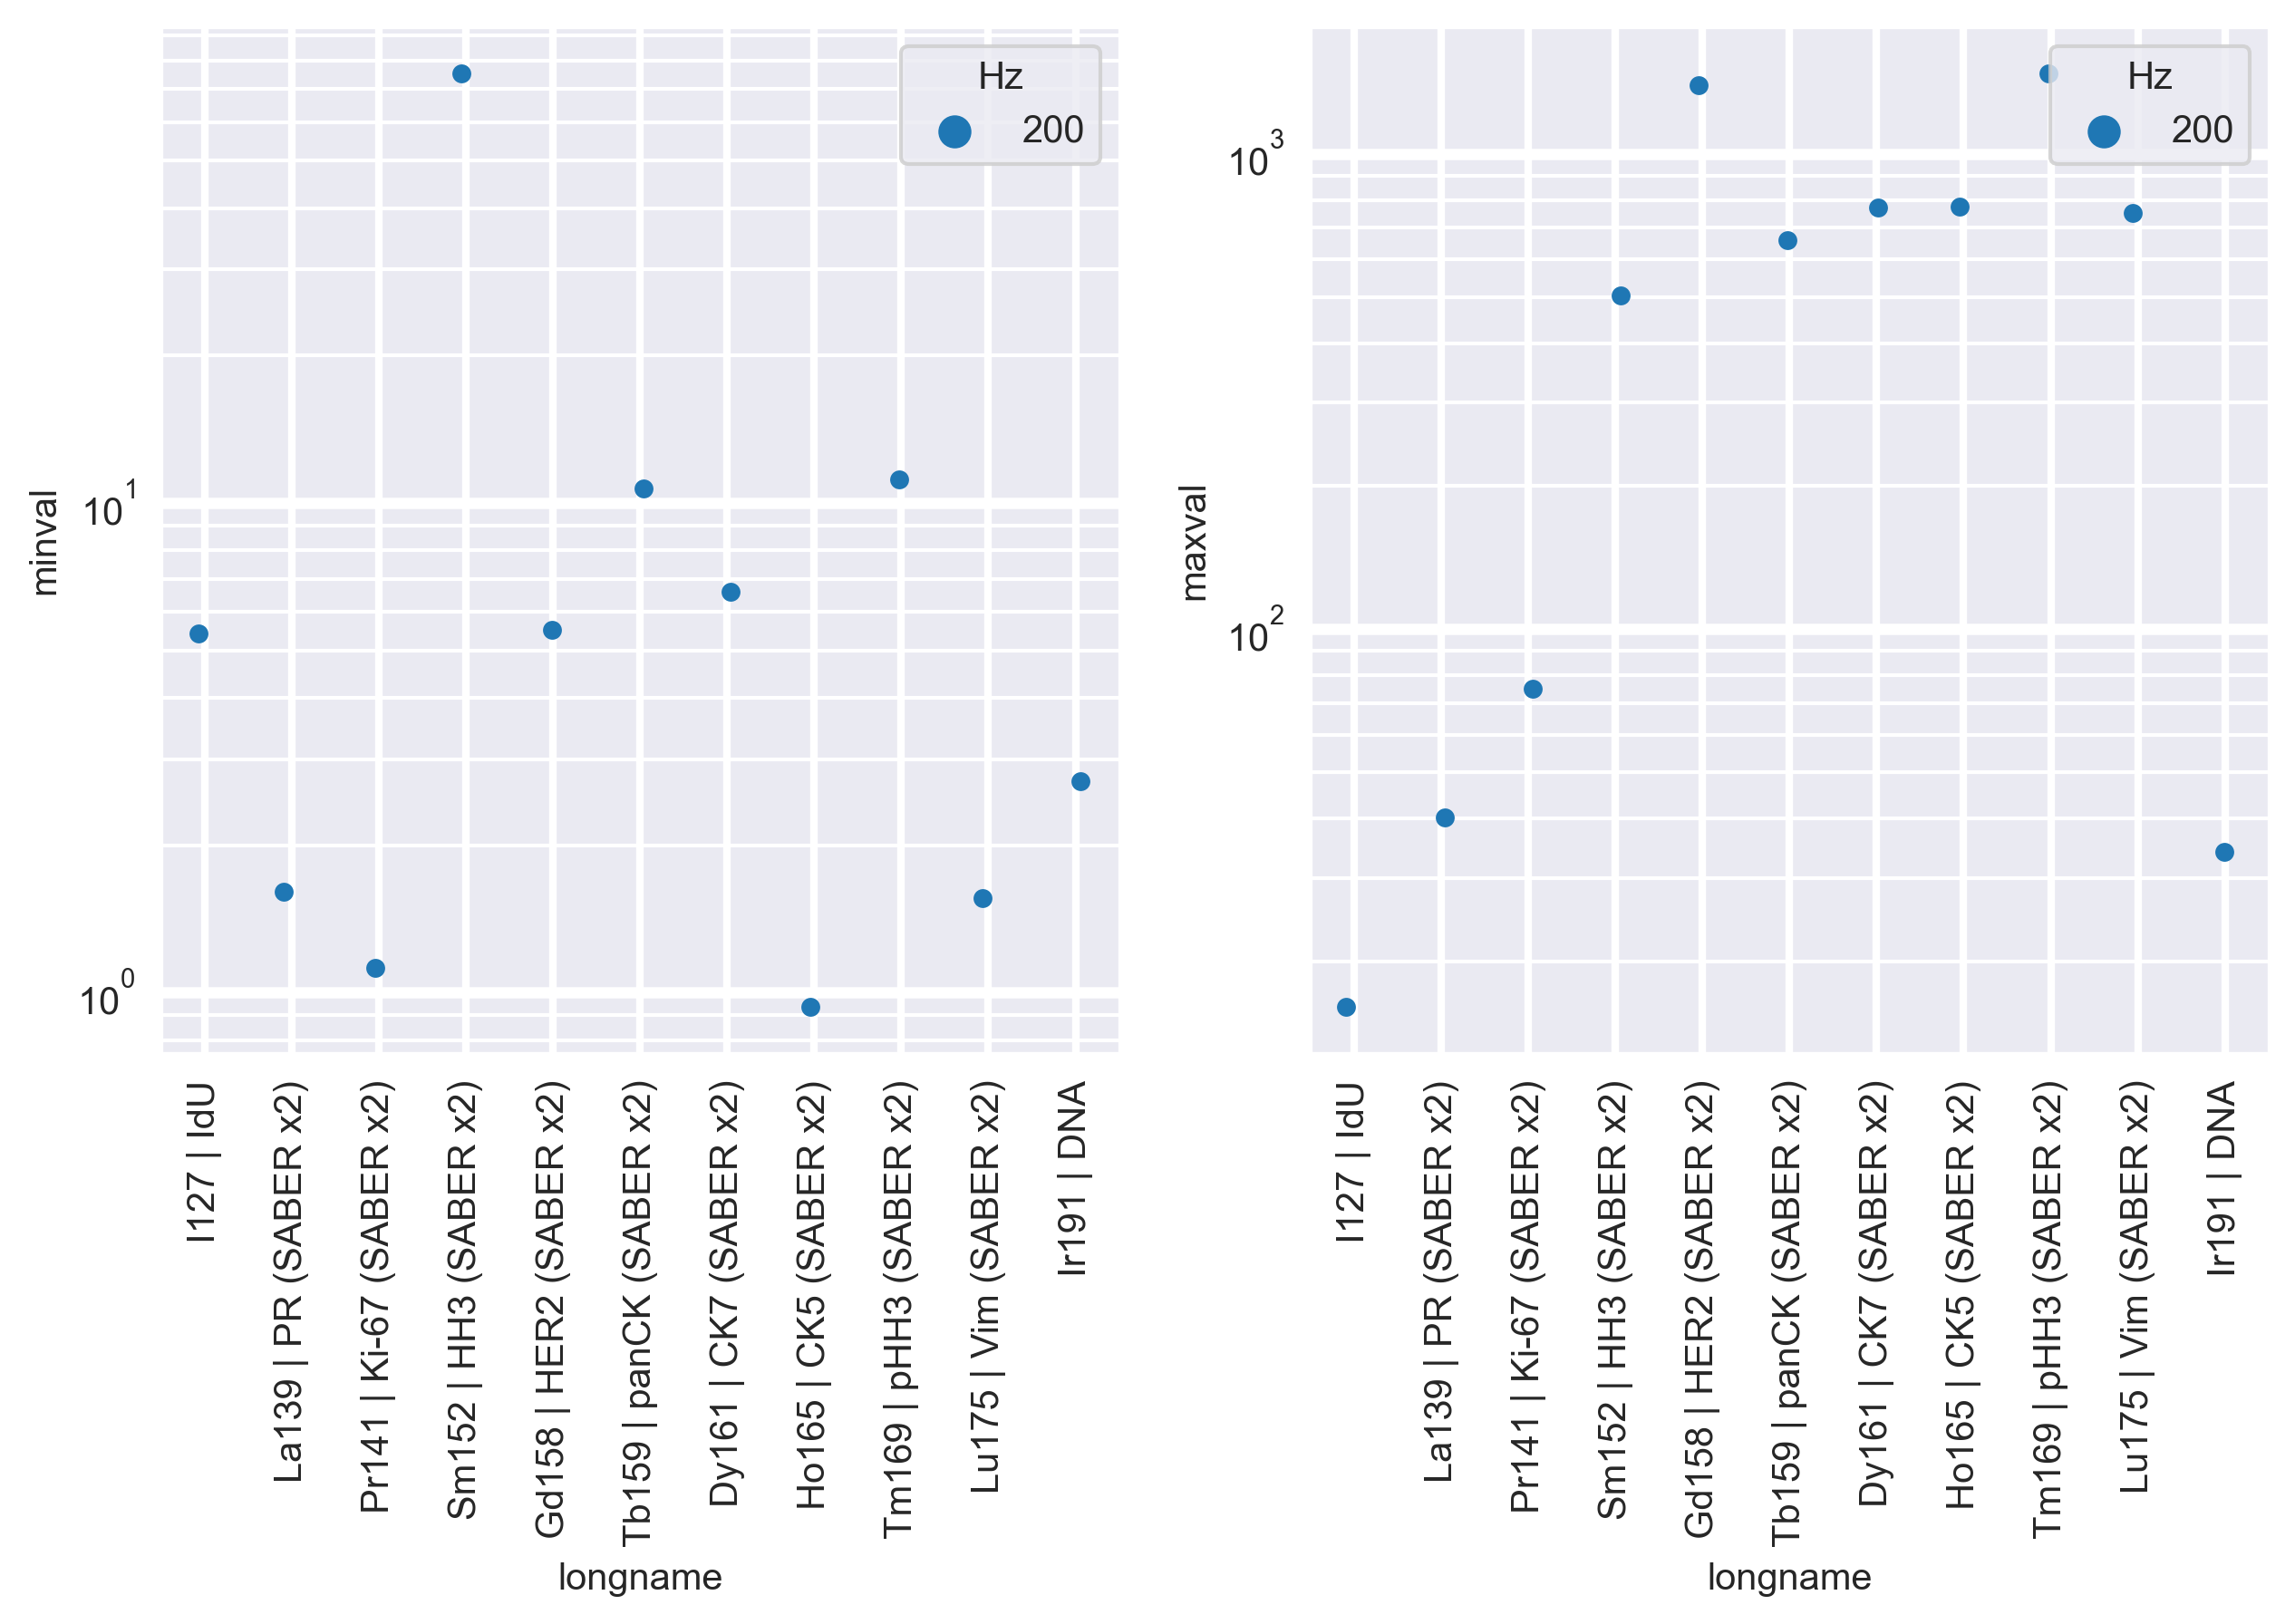

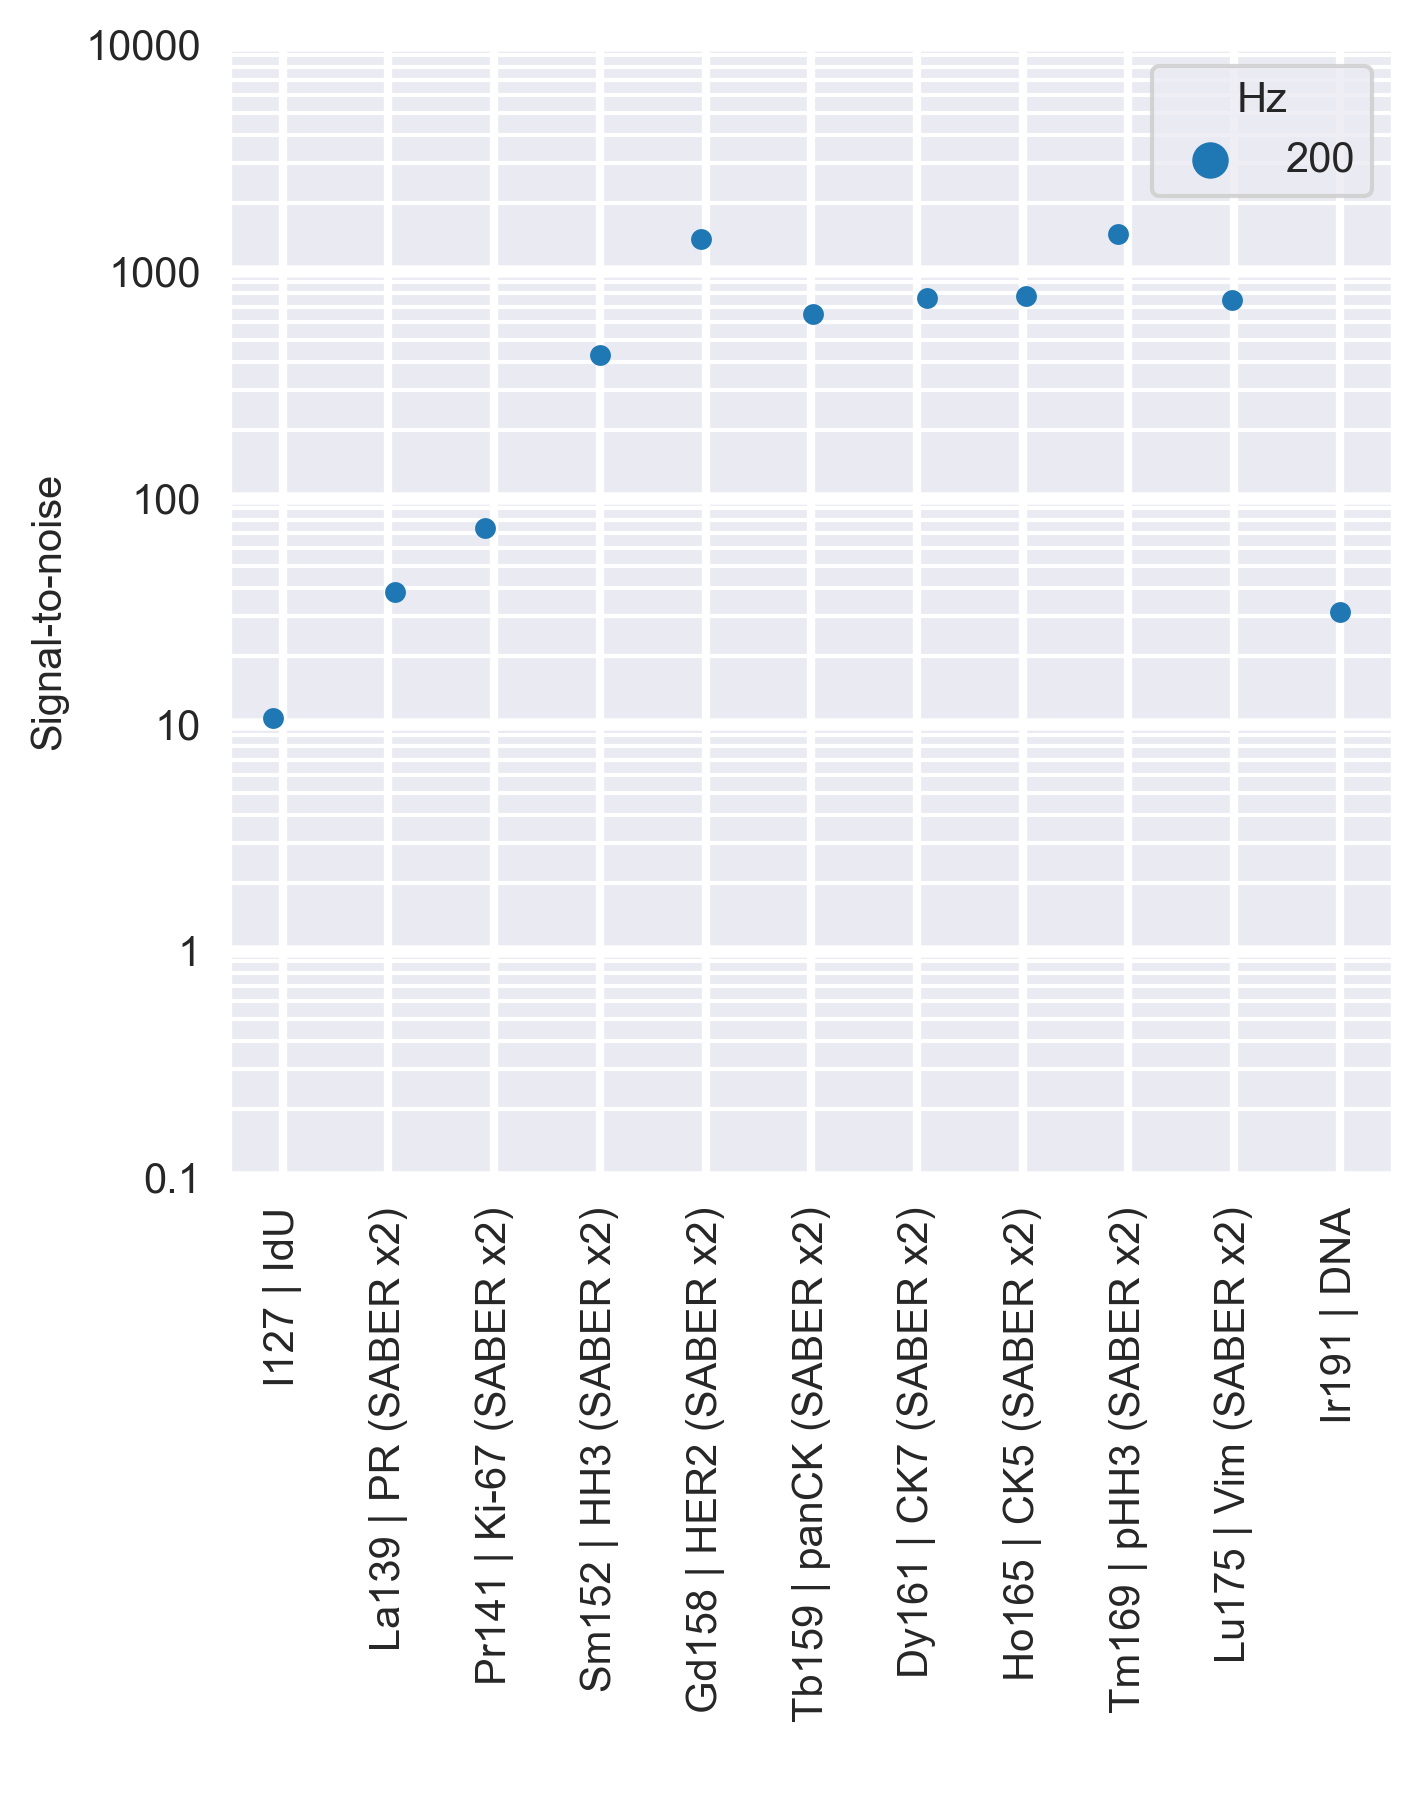

In [14]:
# Set seaborn
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set_style("dark")

### Check max and min values
fig, axs = plt.subplots(ncols = 2, figsize=(10,5), dpi=300)

g = sns.stripplot(
    data = df_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'minval',
    ax=axs[0],
    hue='Hz'
)
axs[0].tick_params(axis='x', rotation=90)

# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

g = sns.stripplot(
    data = df_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'maxval',
    ax=axs[1],
    hue='Hz',
)
axs[1].tick_params(axis='x', rotation=90)


# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

# Sort shared legend
# axs[0].get_legend().remove()
# axs[1].get_legend().remove()
# plt.legend(title='Raster rate (Hz)', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)#, ha='right')
plt.show()

### Plot signal to noise
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
g = sns.stripplot(
    data = df_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'signal-to-noise',
    ax=ax,
    hue='Hz'
)
ax.set(yscale="log")
ax.set_ylim([0.1, 10000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')
plt.xticks(rotation=90)#, ha='right')
plt.ylabel('Signal-to-noise')
plt.xlabel(' ')
# plt.legend(title='Raster rate (Hz)', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

## IMC and XRF signal to noise of speed cell pellets

In [15]:
adata_xrf_path = pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/processed/xrf/7b_SABER_cell_quantification/cell_pellet_speed_for_signal_to_noise_matched_cell_mask.h5ad')
adata_xrf_path.exists()

adata_xrf = ad.read_h5ad(adata_xrf_path)
adata_xrf.var


shortname                   longname
Dy_Ka    CK 7 (SABER x2)    Dy_Ka | CK 7 (SABER x2)
Gd_Ka    HER2 (SABER x2)    Gd_Ka | HER2 (SABER x2)
Ho_Ka     CK5 (SABER x2)     Ho_Ka | CK5 (SABER x2)
I_Ka                 IdU                 I_Ka | IdU
Ir_L3                DNA                Ir_L3 | DNA
La_Ka      PR (SABER x2)      La_Ka | PR (SABER x2)
Lu_Ka     Vim (SABER x2)     Lu_Ka | Vim (SABER x2)
Pr_Ka   Ki-67 (SABER x2)   Pr_Ka | Ki-67 (SABER x2)
Rh_Ka                DNA                Rh_Ka | DNA
Sm_Ka     HH3 (SABER x2)     Sm_Ka | HH3 (SABER x2)
Tb_Ka  pan CK (SABER x2)  Tb_Ka | pan CK (SABER x2)
Tm_Ka    pHH3 (SABER x2)    Tm_Ka | pHH3 (SABER x2)

In [16]:
df_xrf_signal_to_noise = pd.DataFrame()
for hz in adata_xrf.obs['Hz'].unique():
    row = {}
    row['Hz'] = hz
    adata_Hz = adata_xrf[adata_xrf.obs['Hz'] == hz]
    for var_name in adata_Hz.var_names:
        row['var_name'] = var_name

        var_values = adata_Hz[:,var_name].X

        # Sample the max and mean signal in top and bottom (specified) % of cells
        non_zero_values = sorted(var_values[np.nonzero(var_values)])
        percentage = 1
        cell_sample = int(len(non_zero_values) / 100) * percentage
        row['minval'] = np.mean(non_zero_values[:cell_sample])
        row['maxval'] = np.max(non_zero_values[-cell_sample:])

        # Add rows to dataframe
        if df_xrf_signal_to_noise.empty:
            df_xrf_signal_to_noise = pd.DataFrame(columns=row.keys())            
        df_xrf_signal_to_noise = df_xrf_signal_to_noise.append(row, ignore_index=True)
            
# # Sort data types
df_xrf_signal_to_noise['var_name'] = df_xrf_signal_to_noise['var_name'].astype('category')
df_xrf_signal_to_noise['Hz'] = df_xrf_signal_to_noise['Hz'].astype('category')
df_xrf_signal_to_noise['minval'] = df_xrf_signal_to_noise['minval'].astype('float')
df_xrf_signal_to_noise['maxval'] = df_xrf_signal_to_noise['maxval'].astype('float')
df_xrf_signal_to_noise['signal-to-noise'] = (df_xrf_signal_to_noise['maxval'] - (df_xrf_signal_to_noise['minval']))
 
df_xrf_signal_to_noise['xrf_emission'] = df_xrf_signal_to_noise['var_name'].str.split(' ', expand=True).iloc[:,0]
# df_xrf_signal_to_noise[['ab_tag', 'shortname']] = df_xrf_signal_to_noise['var_name'].str.split(' ', expand=True).iloc[:,[0,2]].rename(columns={0:'ab_tag', 1:'shortname'})
df_xrf_signal_to_noise = pd.merge(df_xrf_signal_to_noise, df_to_map, left_on='xrf_emission', right_on='xrf_emission', suffixes=('', '_y'))
df_xrf_signal_to_noise.drop(df_xrf_signal_to_noise.filter(regex='_y$').columns, axis=1, inplace=True)
df_xrf_signal_to_noise['Method'] = 'XRF (GeCMOS 2nd)'
df_xrf_signal_to_noise

C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Hz var_name     minval      maxval  signal-to-noise xrf_emission  \
0     10    Dy_Ka  83.247818  752.589966       669.342148        Dy_Ka   
1     50    Dy_Ka  16.646978  168.042831       151.395853        Dy_Ka   
2    250    Dy_Ka   2.903760   31.871246        28.967486        Dy_Ka   
3    500    Dy_Ka   1.195692   23.609011        22.413319        Dy_Ka   
4    800    Dy_Ka   0.908445   11.345567        10.437122        Dy_Ka   
..   ...      ...        ...         ...              ...          ...   
72   250    Tm_Ka   6.138427   58.592377        52.453950        Tm_Ka   
73   500    Tm_Ka   2.689979   36.484600        33.794621        Tm_Ka   
74   800    Tm_Ka   2.161254   31.571775        29.410522        Tm_Ka   
75  1000    Tm_Ka   1.683380   20.490774        18.807394        Tm_Ka   
76  1500    Tm_Ka   1.042341   15.169022        14.126680        Tm_Ka   

          shortname                 longname ab_tag  tag_isotope  ...  \
0    CK7 (SABER x2)   Dy161 | CK7 (SABER x2)  Dy161        161.0  ...   
1    CK7 (SABER x2)   Dy161 | CK7 (SABER x2)  Dy161        161.0  ...   
2    CK7 (SABER x2)   Dy161 | CK7 (SABER x2)  Dy161        161.0  ...   
3    CK7 (SABER x2)   Dy161 | CK7 (SABER x2)  Dy161        161.0  ...   
4    CK7 (SABER x2)   Dy161 | CK7 (SABER x2)  Dy161        161.0  ...   
..              ...                      ...    ...          ...  ...   
72  pHH3 (SABER x2)  Tm169 | pHH3 (SABER x2)  Tm169        169.0  ...   
73  pHH3 (SABER x2)  Tm169 | pHH3 (SABER x2)  Tm169        169.0  ...   
74  pHH3 (SABER x2)  Tm169 | pHH3 (SABER x2)  Tm169        169.0  ...   
75  pHH3 (SABER x2)  Tm169 | pHH3 (SABER x2)  Tm169        169.0  ...   
76  pHH3 (SABER x2)  Tm169 | pHH3 (SABER x2)  Tm169        169.0  ...   

   stock_conc_ug_per_ml  use_conc_ug_per_mL nuclear_segment  cell_segment  \
0                   NaN                 NaN             NaN           1.0   
1                   NaN                 NaN             NaN           1.0   
2                   NaN                 NaN             NaN           1.0   
3                   NaN                 NaN             NaN           1.0   
4                   NaN                 NaN             NaN           1.0   
..                  ...                 ...             ...           ...   
72                  NaN                 NaN             NaN           NaN   
73                  NaN                 NaN             NaN           NaN   
74                  NaN                 NaN             NaN           NaN   
75                  NaN                 NaN             NaN           NaN   
76                  NaN                 NaN             NaN           NaN   

         SABER              longname_mod  Symbol AtomicNumber     Element  \
0   (SABER x2)  Dy161 | Dy161#(SABER x2)      Dy           66  Dysprosium   
1   (SABER x2)  Dy161 | Dy161#(SABER x2)      Dy           66  Dysprosium   
2   (SABER x2)  Dy161 | Dy161#(SABER x2)      Dy           66  Dysprosium   
3   (SABER x2)  Dy161 | Dy161#(SABER x2)      Dy           66  Dysprosium   
4   (SABER x2)  Dy161 | Dy161#(SABER x2)      Dy           66  Dysprosium   
..         ...                       ...     ...          ...         ...   
72  (SABER x2)  Tm169 | Tm169#(SABER x2)      Tm           69     Thulium   
73  (SABER x2)  Tm169 | Tm169#(SABER x2)      Tm           69     Thulium   
74  (SABER x2)  Tm169 | Tm169#(SABER x2)      Tm           69     Thulium   
75  (SABER x2)  Tm169 | Tm169#(SABER x2)      Tm           69     Thulium   
76  (SABER x2)  Tm169 | Tm169#(SABER x2)      Tm           69     Thulium   

              Method  
0   XRF (GeCMOS 2nd)  
1   XRF (GeCMOS 2nd)  
2   XRF (GeCMOS 2nd)  
3   XRF (GeCMOS 2nd)  
4   XRF (GeCMOS 2nd)  
..               ...  
72  XRF (GeCMOS 2nd)  
73  XRF (GeCMOS 2nd)  
74  XRF (GeCMOS 2nd)  
75  XRF (GeCMOS 2nd)  
76  XRF (GeCMOS 2nd)  

[77 rows x 23 columns]

In [17]:
df_collated_signal_to_noise = df_signal_to_noise[['Hz', 'minval', 'maxval', 'signal-to-noise', 'ab_tag', 'Symbol', 'longname', 'AtomicNumber', 'Element', 'Method']]
df_collated_signal_to_noise = df_collated_signal_to_noise.append(df_xrf_signal_to_noise[df_collated_signal_to_noise.columns], ignore_index=True)
df_collated_signal_to_noise['Hz'] = df_collated_signal_to_noise['Hz'].astype('int')
# df_collated_signal_to_noise = df_collated_signal_to_noise[df_collated_signal_to_noise['Symbol'] != 'Ir']

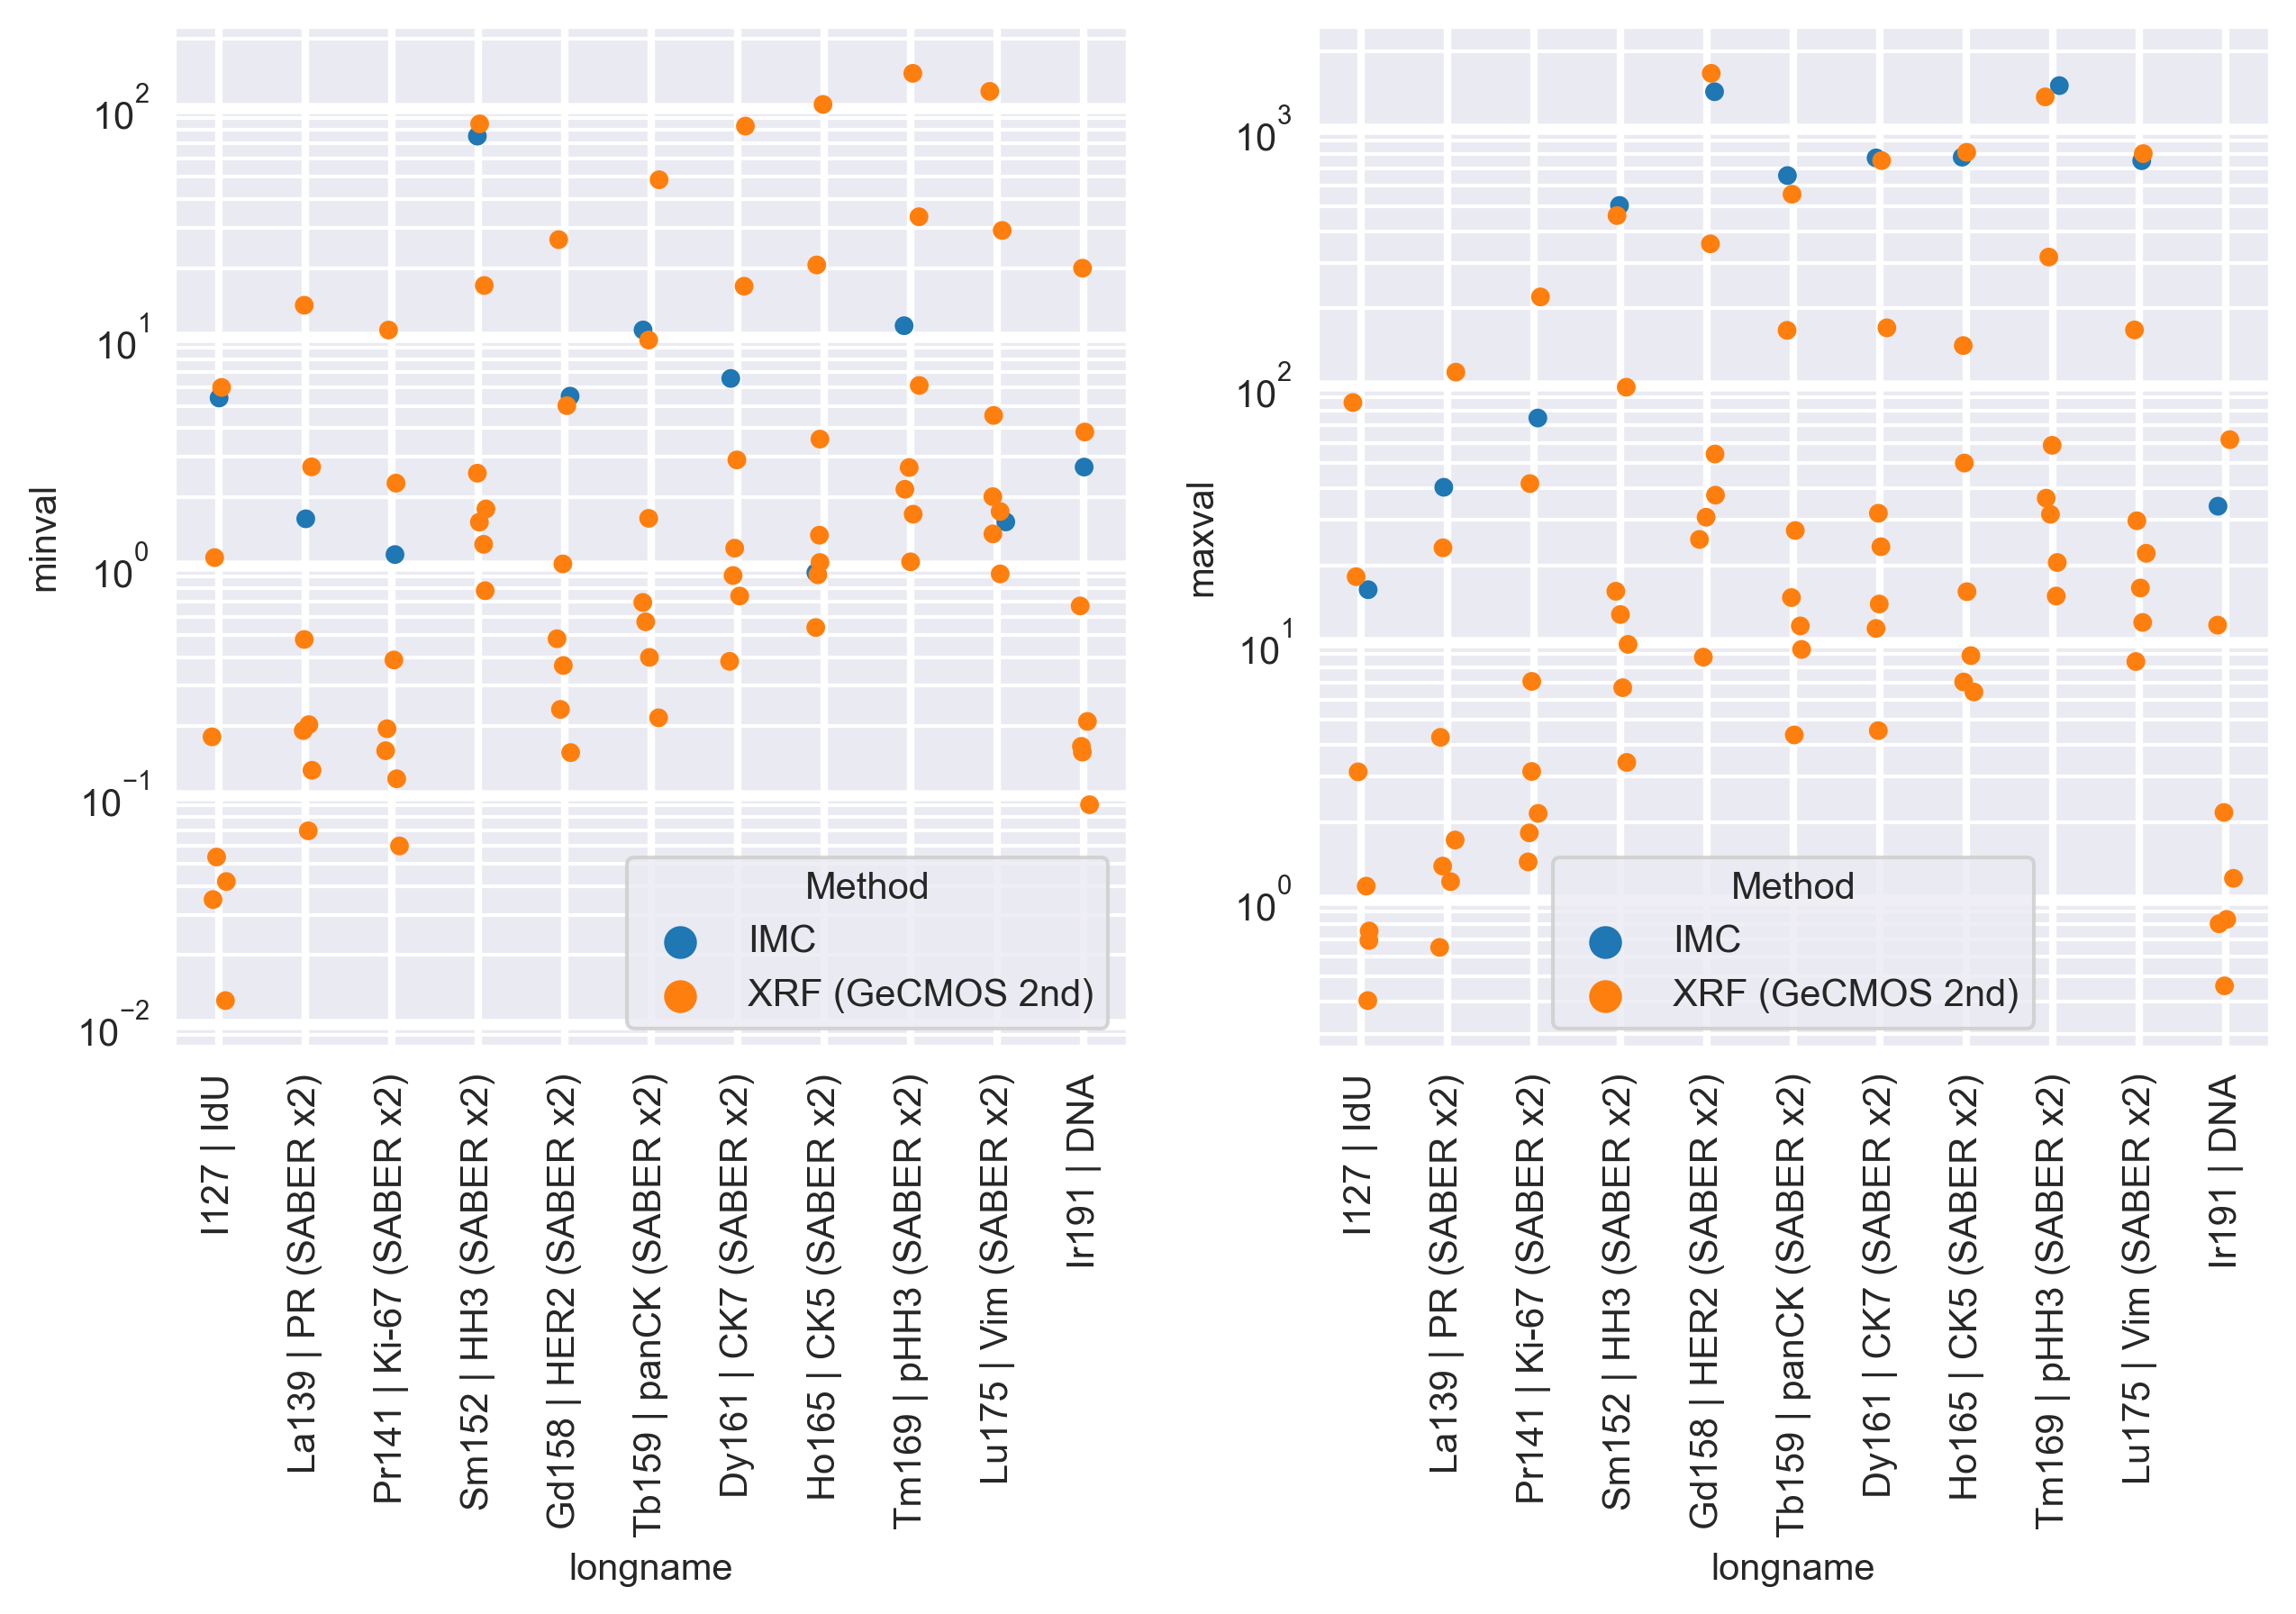

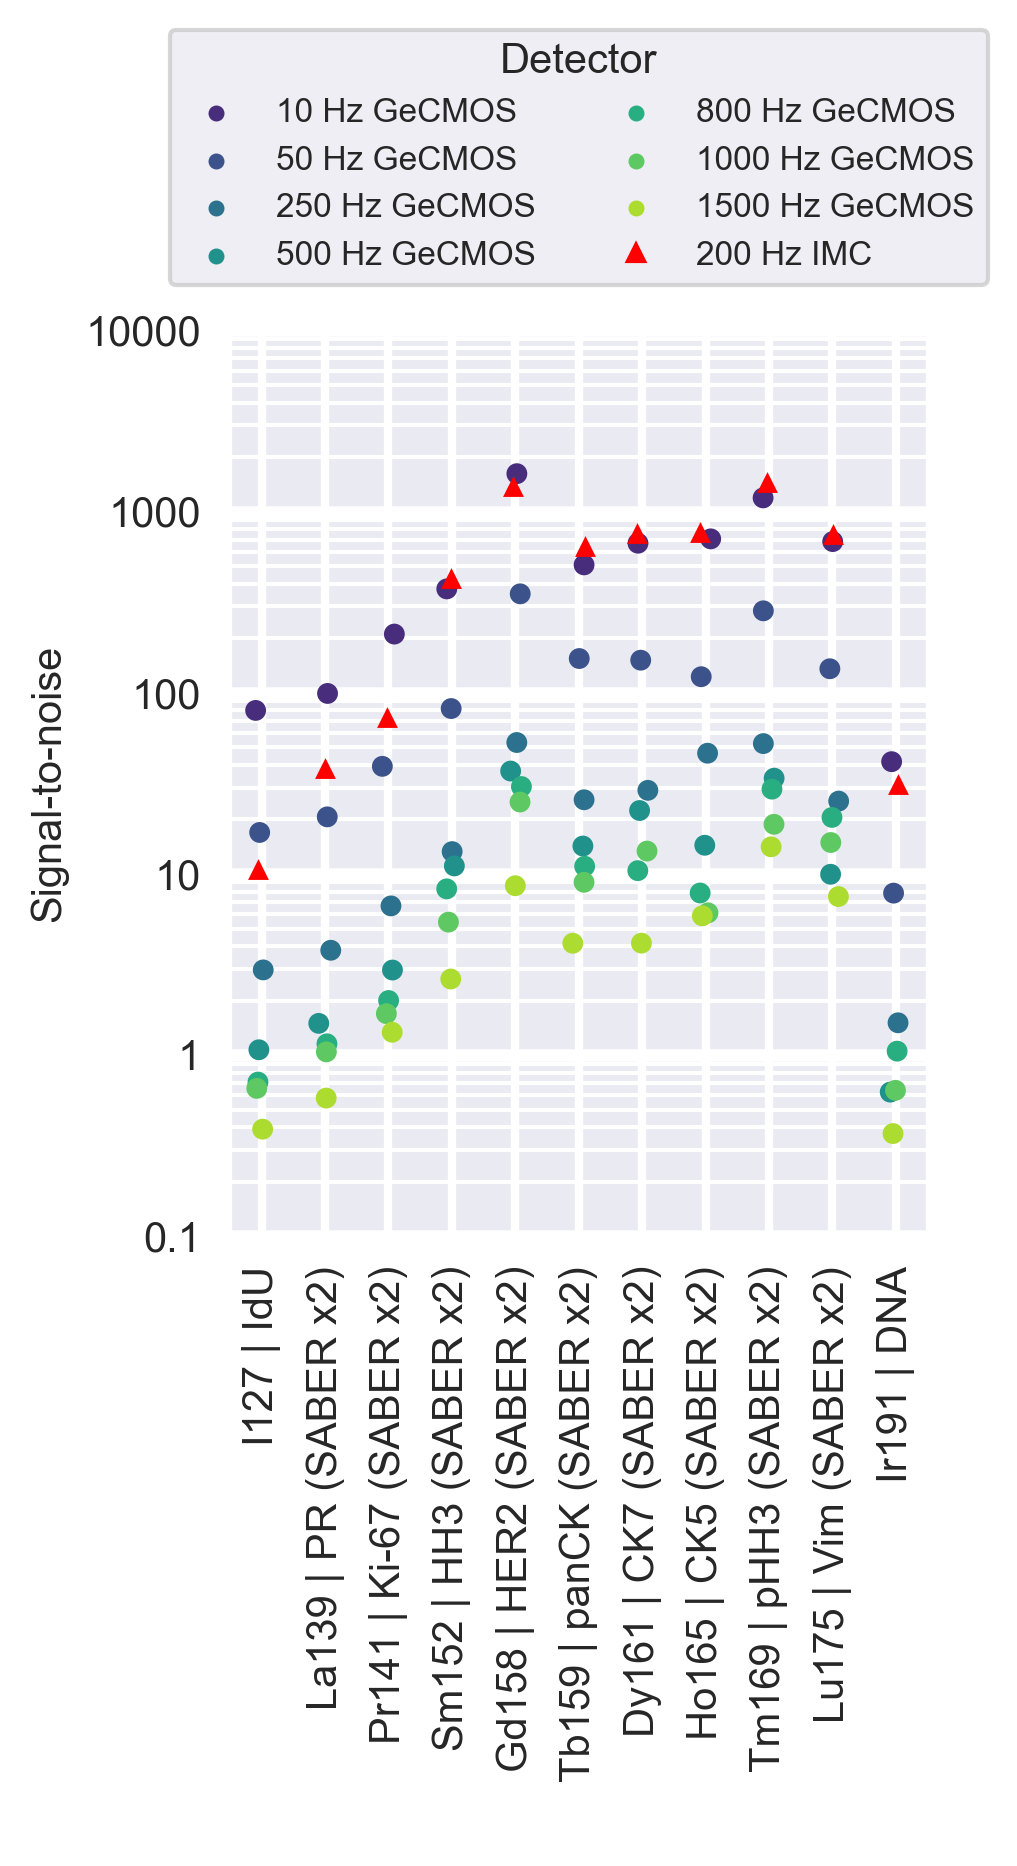

In [18]:
# Set seaborn
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set_style("dark")

### Check max and min values
fig, axs = plt.subplots(ncols = 2, figsize=(10,5), dpi=300)

g = sns.stripplot(
    data = df_collated_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'minval',
    ax=axs[0],
    hue='Method'
)
axs[0].tick_params(axis='x', rotation=90)

# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

g = sns.stripplot(
    data = df_collated_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'maxval',
    ax=axs[1],
    hue='Method'
)
axs[1].tick_params(axis='x', rotation=90)

# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

plt.xticks(rotation=90)#, ha='right')
plt.show()

### Plot signal to noise
fig, ax = plt.subplots(figsize=(3,4), dpi=300)
g = sns.stripplot(
    data = df_collated_signal_to_noise[df_collated_signal_to_noise['Method'] == 'XRF (GeCMOS 2nd)'],
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'signal-to-noise',
    ax=ax,
    hue='Hz',    
    palette = 'viridis'
)

g = sns.stripplot(
    data = df_collated_signal_to_noise[df_collated_signal_to_noise['Method'] == 'IMC'],
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'signal-to-noise',
    ax=ax,
    hue='Method',  
    palette = ['red'],
    marker='^',
)

ax.set(yscale="log")
ax.set_ylim([0.1, 10000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# Custom set the marker for IMC
handles, labels = ax.get_legend_handles_labels()
red_triangle = mlines.Line2D([], [], color='red', marker='^', linestyle='None', markersize=4, label='Purple triangles')
handles[-1] = red_triangle

lgd = plt.legend(
    title='Detector',
    loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2,
    borderaxespad=0., 
    labels=['10 Hz GeCMOS', '50 Hz GeCMOS', '250 Hz GeCMOS', '500 Hz GeCMOS', '800 Hz GeCMOS', '1000 Hz GeCMOS', '1500 Hz GeCMOS', '200 Hz IMC'],
    handles = handles,
    fontsize=8
)

for legend_handle in lgd.legendHandles[:-1]:
    legend_handle.set_sizes([8])

g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')
plt.xticks(rotation=90)#, ha='right')
plt.ylabel('Signal-to-noise')
plt.xlabel(' ')

savename = out_dir / 'Fig4M_XRFIMCSABERcomparison.svg'
print(savename)
plt.savefig(savename, bbox_inches='tight')

plt.show()